# extract dataset

In [ ]:
!unzip -q drive/My\ Drive/carla/dataset/dataset.zip 

In [ ]:
%matplotlib inline

# analysis of dataset

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

% matplotlib inline

In [ ]:
data = pd.read_csv('dataset/dataset.csv', delimiter=',', header=None)
data = data.iloc[:,1:6]

In [ ]:
data.describe()

In [ ]:
!head /content/dataset/dataset.csv

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8a7e17f60>,
      dtype=object)

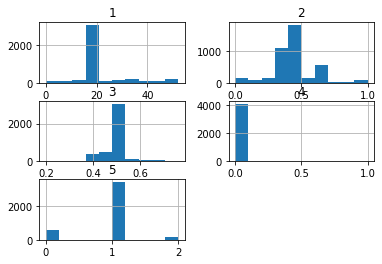

In [ ]:
data.hist()

In [ ]:
def getIndex(data):
    index = []
    for i in range(data.shape[0]):
        row = data[i, :]
        if row[-1] == 1:
            if row[-2] == 0.0:
                if row[2] > 0.48 and row[2] < 0.52:
                    if row[0] > 15 and row[1] < 20:
                        index.append(i)
    
    return index
                        

def filter(data):
    d = data.drop(getIndex(data.to_numpy()))
    return d

In [ ]:
d = filter(data)
d.describe()

,1,2,3,4,5
count,1553.000000,1553.000000,1553.000000,1553.000000,1553.000000
mean,16.578815,0.422395,0.476603,0.033612,0.752093
std,6.639723,0.187100,0.083147,0.165800,0.655840
min,0.000000,0.000000,0.200000,0.000000,0.000000
25%,16.760000,0.340000,0.415000,0.000000,0.000000
50%,16.840000,0.440000,0.470000,0.000000,1.000000
75%,17.910000,0.450000,0.505000,0.000000,1.000000
max,51.500000,1.000000,0.760000,1.000000,2.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc89f8b15c0>,
      dtype=object)

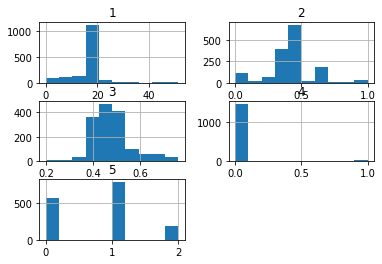

In [ ]:
d.hist()

#models definition

## direction model

In [ ]:
# necessary imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, Conv1D, MaxPooling2D
from tensorflow.keras.utils import plot_model
import tensorflow as tf
import sys

In [ ]:
def directionModel(shape=(144, 144, 3), option="flatten"):
    visible = Input(shape=shape)

    conv1 = Conv2D(16, kernel_size=5, activation='relu', padding='valid')(visible)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(32, kernel_size=3, activation='relu', padding='valid')(pool1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(64, kernel_size=3, activation='relu', padding='valid')(pool2)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(128, kernel_size=3, activation='relu', padding='valid')(pool3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # way 1 to flatten - many params
    if option == 'flatten':
        flat = Flatten()(pool4)

    # way 2 to flatten - less params
    elif option == 'conv1d':
        conv5 = Conv1D(1024, kernel_size=3, activation='relu', padding='same')(pool4)
        flat  = MaxPooling2D(pool_size=(conv5.shape[1], conv5.shape[2]))(conv5)
        flat = tf.squeeze(flat, axis=[1, 2])

    # mentioned method doesn't exist
    else:
        print("\nInvalid flatten option")
        sys.exit(1)

    hidden1 = Dense(512, activation='relu')(flat)
    hidden2 = Dense(128, activation='relu')(hidden1)

    # direction
    output1 = Dense(3, activation='softmax')(hidden2)

    model = Model(inputs=visible, outputs=output1)
    return model


In [ ]:

model = directionModel()
#model.summary()
#plot_model(model)

## signals model

In [ ]:
def signalsModel():
    input = Input(shape=(2))

    hidden1 = Dense(16, activation='relu')(input)
    hidden2 = Dense(32, activation='relu')(hidden1)
    hidden3 = Dense(64, activation='relu')(hidden2)
    hidden4 = Dense(32, activation='relu')(hidden3)

    output = Dense(3, activation='sigmoid')(hidden4)

    model = Model(inputs=input, outputs=output)
    return model

In [ ]:
model = signalsModel()
#model.summary()
#plot_model(model)

# preprocessing

In [ ]:
import csv
import cv2
import sys
import os
import numpy as np

In [ ]:
BASE_PATH = "/content/"
file = BASE_PATH + "/dataset/dataset.csv"

## process signals

In [ ]:
def choose_dir(s):
    x = s[-2]
    if x < 0.45:
        return 0
    elif x > 0.55:
        return 2
    return 1

def convert(r):
    for i in range(1, len(r)):
        r[i] = round(float(r[i]), 2)
    r[-2] = (r[-2] + 1) / 2.0
    return r

def process_signals(file):
    signals = []
    with open(file, 'r') as f:
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            signals.append(row)

    print(signals[0])
    signals = list(map(convert, signals))
    print(signals[0])
    dir = list(map(choose_dir, signals))
    print(signals[0])

    for i in range(len(dir)):
        signals[i].append(dir[i])

    print(signals[0])
    with open(file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows(signals)

## process images

In [ ]:
def process_images(file, BASE_PATH, dim):
    files = []
    names = []
    with open(file) as f:
        try:
            os.makedirs('/content/dataset/train/0')
            os.makedirs('/content/dataset/train/1')
            os.makedirs('/content/dataset/train/2')
        except:
            pass
            
        reader = csv.reader(f, delimiter=',')
        for row in reader:
            files.append(BASE_PATH + "/dataset/" + row[0])
            if row[-1] == '0' :
                names.append(BASE_PATH+"dataset/train/0/"+row[0])
            elif row[-1] == '1' :
                names.append(BASE_PATH+"dataset/train/1/"+row[0])
            else:
                names.append(BASE_PATH+"dataset/train/2/"+row[0])

    i = 0
    for fname in files:    
        img = cv2.imread(fname)
        img = cv2.Canny(img,70,100)
        height, width = img.shape[:2]

        start_row, start_col = int(height * .5), int(0)
        end_row, end_col = int(height), int(width)
        img = img[start_row:end_row , start_col:end_col]

        img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
        cv2.imwrite(names[i], img)
        i += 1

In [ ]:
process_signals(file)

['00055091.png', '17.93198859935223', '0.3407810926437378', '0.06523145735263824', '0.0']
['00055091.png', 17.93, 0.34, 0.535, 0.0]
['00055091.png', 17.93, 0.34, 0.535, 0.0]
['00055091.png', 17.93, 0.34, 0.535, 0.0, 1]


In [ ]:
process_images(file, BASE_PATH, (144, 144))

#helper functions start

In [ ]:
# imports
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow
import pandas as pd

In [ ]:
# global variables
DATASET_PATH = '/content/dataset/train/'
BATCH_SIZE = 256

## load input images

In [ ]:
def load_data_direction(train_path, test_path, BATCH_SIZE):
    train_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.33) # normalize image value between 0.0 to 1.0
    #test_datagen = ImageDataGenerator(rescale=1.0/255.0)
    train_gen = train_datagen.flow_from_directory(
        train_path, batch_size=BATCH_SIZE, color_mode='grayscale', 
        target_size=(144, 144), class_mode='sparse', subset='training')
    test_gen = train_datagen.flow_from_directory(
        test_path, batch_size=BATCH_SIZE, color_mode='grayscale', 
        target_size=(144, 144), class_mode='sparse', subset='validation')

    return train_gen, test_gen

In [ ]:
train, test = load_data_direction(DATASET_PATH, DATASET_PATH, BATCH_SIZE)
print(type(train))
print(type(test))

Found 2809 images belonging to 3 classes.
Found 1382 images belonging to 3 classes.
<class 'tensorflow.python.keras.preprocessing.image.DirectoryIterator'>
<class 'tensorflow.python.keras.preprocessing.image.DirectoryIterator'>


## load signals

In [ ]:
def getIndex(data):
    index = []
    for i in range(data.shape[0]):
        row = data[i, :]
        if row[-1] == 1:
            if row[-2] == 0.0:
                if row[2] > 0.48 and row[2] < 0.52:
                    if row[0] > 15 and row[1] < 20:
                        index.append(i)
    
    return index
                        
def filter(data):
    d = data.drop(getIndex(data.to_numpy()))
    return d

def load_data_signals(train_path, test_path):
    data = pd.read_csv(train_path, delimiter=',', header=None)
    data = data.iloc[:,1:6]

    data = filter(data)
    data = data.sample(frac=1)
    split = data.shape[0]

    split = int(split * 2 / 3)

    X_train = pd.DataFrame()
    Y_train = pd.DataFrame()

    X_train['speed'] = data.iloc[0:split,0]
    X_train['dir'] = data.iloc[0:split,4]

    Y_train['throttle'] = data.iloc[0:split, 1]
    Y_train['steer'] = data.iloc[0:split, 2]
    Y_train['brake'] = data.iloc[0:split,3].apply(lambda y: 0.0 if y < 0.5 else 1.0)

    X_test = pd.DataFrame()
    Y_test = pd.DataFrame()

    X_test['speed'] = data.iloc[split:,0]
    X_test['dir'] = data.iloc[split:,4]

    Y_test['throttle'] = data.iloc[split:, 1]
    Y_test['steer'] = data.iloc[split:, 2]
    Y_test['brake'] = data.iloc[split:,3].apply(lambda y: 0.0 if y < 0.5 else 1.0)
    
    return X_train, X_test, Y_train, Y_test

In [ ]:
xtrain, xtest, ytrain, ytest = load_data_signals(file, file)
print(type(xtrain))

<class 'pandas.core.frame.DataFrame'>


In [ ]:
print(xtest.shape)

(518, 2)


# train models

## train direction model

In [ ]:
dir_model = directionModel(shape=(144, 144, 1))
dir_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 144, 144, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 140, 140, 16)      416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 70, 70, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 68, 68, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 64)       

In [ ]:
dir_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', 
                  metrics=['acc'])

In [ ]:
history = dir_model.fit(train, epochs=10, validation_data=test, verbose=1)

Epoch 1/10
11/11 [==============================] - 57s 5s/step - loss: 0.5783 - acc: 0.8095 - val_loss: 0.3199 - val_acc: 0.8184
Epoch 2/10
11/11 [==============================] - 56s 5s/step - loss: 0.2074 - acc: 0.9220 - val_loss: 0.1615 - val_acc: 0.9595
Epoch 3/10
11/11 [==============================] - 56s 5s/step - loss: 0.1235 - acc: 0.9662 - val_loss: 0.1056 - val_acc: 0.9530
Epoch 4/10
11/11 [==============================] - 56s 5s/step - loss: 0.0877 - acc: 0.9708 - val_loss: 0.0800 - val_acc: 0.9747
Epoch 5/10
11/11 [==============================] - 56s 5s/step - loss: 0.0642 - acc: 0.9808 - val_loss: 0.0933 - val_acc: 0.9667
Epoch 6/10
11/11 [==============================] - 56s 5s/step - loss: 0.0514 - acc: 0.9843 - val_loss: 0.1032 - val_acc: 0.9667
Epoch 7/10
11/11 [==============================] - 57s 5s/step - loss: 0.0422 - acc: 0.9854 - val_loss: 0.1244 - val_acc: 0.9653
Epoch 8/10
11/11 [==============================] - 56s 5s/step - loss: 0.0284 - acc: 0.99

In [ ]:
from PIL import Image
img = Image.open('/content/dataset/train/1/00006074.png')
img = np.array(img)
img = img / 255.0
img = np.expand_dims(img, axis=-1)
img = np.expand_dims(img, axis=0)
img = tf.constant(img)
print(img.shape)

(1, 144, 144, 1)


In [ ]:
dir_model.predict(img)

array([[3.39443710e-14, 1.00000000e+00, 1.18396105e-14]], dtype=float32)

## train signals model


In [ ]:
sig_model = signalsModel()
sig_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_5 (Dense)              (None, 16)                48        
_________________________________________________________________
dense_6 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 3)                 99        
Total params: 4,883
Trainable params: 4,883
Non-trainable params: 0
____________________________________________________

In [ ]:
sig_model.compile(optimizer='adam', loss='mse', metrics=['acc'])

In [ ]:
ytest.shape

(1190, 3)

In [ ]:
his = sig_model.fit(x=xtrain, y=ytrain, epochs=100, verbose=1, validation_data=(xtest.to_numpy(), ytest.to_numpy()))

Epoch 1/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0154 - acc: 0.8135 - val_loss: 0.0149 - val_acc: 0.7915
Epoch 2/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0165 - acc: 0.7855 - val_loss: 0.0139 - val_acc: 0.8649
Epoch 3/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0161 - acc: 0.7768 - val_loss: 0.0156 - val_acc: 0.8378
Epoch 4/100
33/33 [==============================] - 0s 3ms/step - loss: 0.0181 - acc: 0.7623 - val_loss: 0.0163 - val_acc: 0.7722
Epoch 5/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0187 - acc: 0.7478 - val_loss: 0.0168 - val_acc: 0.6429
Epoch 6/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0185 - acc: 0.7082 - val_loss: 0.0160 - val_acc: 0.8629
Epoch 7/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0183 - acc: 0.7353 - val_loss: 0.0159 - val_acc: 0.7780
Epoch 8/100
33/33 [==============================] - 0s 2ms/step - loss: 0.0181 - a

In [ ]:
inp = np.array([44.92, 1])
inp = np.expand_dims(inp, axis=0)
print(sig_model.predict(inp))

[[0.50492066 0.50044537 0.02602342]]


# test the overall stack

In [ ]:
from PIL import Image
import numpy as np

In [ ]:
def predict(filename, speed):
    img = Image.open(filename)
    img = np.array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=-1)
    img = np.expand_dims(img, axis=0)
    img = tf.constant(img)

    dir = dir_model.predict(img)
    dir = dir.argmax()

    inp = np.array([speed, dir])
    inp = np.expand_dims(inp, axis=0)
    signals = sig_model.predict(inp)
    return signals

In [ ]:
predict('/content/dataset/train/0/00005858.png', 16.69)

array([[4.1445628e-01, 4.1284758e-01, 8.5142528e-06]], dtype=float32)

# save models

In [ ]:
dir_model.save('DirModel.h5')
sig_model.save('SigModel.h5')

In [ ]:
!cp SigModel.h5 drive/My\ Drive/carla

In [ ]:
!ls drive/My\ Drive/carla

dataset  DirModel.h5  SigModel.h5  win-build.zip
